<a href="https://colab.research.google.com/github/GrimmerJR/Portfolio/blob/main/BTC_and_SPX_Rolling_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [8]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import random

In [9]:
# Download data for Bitcoin (BTC-USD) and S&P 500 (^GSPC) from Yahoo Finance
start_date = '2019-01-01'
end_date = '2024-09-12'
bitcoin_data = yf.download('BTC-USD', start=start_date, end=end_date)['Adj Close']
spx_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# Align the data by date and drop missing values
data_btc_spx = pd.concat([bitcoin_data, spx_data], axis=1)
data_btc_spx.columns = ['Bitcoin', 'S&P 500']
data_btc_spx.dropna(inplace=True)

In [11]:
# Calculate rolling correlation (30-day window) between Bitcoin and S&P 500
window_size = 30
data_btc_spx['Rolling_Correlation'] = data_btc_spx['Bitcoin'].rolling(window=window_size).corr(data_btc_spx['S&P 500'])

In [12]:

# Drop missing values after calculating rolling correlation
data_btc_spx.dropna(inplace=True)

# Normalize the data for LSTM model in the range of -1 to 1 (appropriate for correlation)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data_btc_spx['Rolling_Correlation'].values.reshape(-1, 1))

In [14]:
# Create dataset for LSTM model where X is past 60 timesteps and Y is the next timeste
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

In [15]:
# Reshape data to 3D array for LSTM [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add Dropout layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(units=25))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=64, epochs=25)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.2024
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0689
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0499
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0375
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0309
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0269
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0265
Epoch 8/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0236
Epoch 9/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0206
Epoch 10/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0189
Epoch 11/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0194
Epoch 12/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0158
Epoch 13/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.0155
Epoch 14/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0159
Epoch 15/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - lo

In [18]:
# Evaluate model accuracy using Root Mean Squared Error (RMSE)
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 0.08740612252241647


In [19]:
# Prepare data for plotting
train_data = data_btc_spx['Rolling_Correlation'][:train_size + time_step]
test_data = data_btc_spx['Rolling_Correlation'][train_size + time_step:]
test_data = pd.DataFrame(test_data, columns=['Rolling_Correlation'])
test_data['Predictions'] = predictions

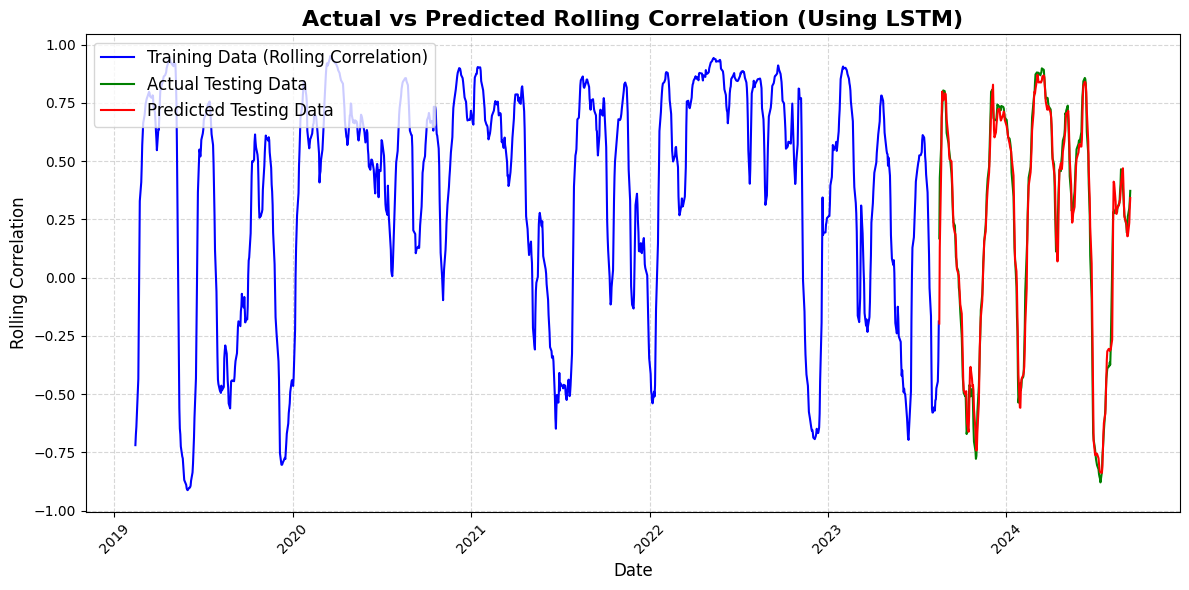

In [20]:
# Plot the results using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data, label='Training Data (Rolling Correlation)', color='blue')
sns.lineplot(x=test_data.index, y=test_data['Rolling_Correlation'], label='Actual Testing Data', color='green')
sns.lineplot(x=test_data.index, y=test_data['Predictions'], label='Predicted Testing Data', color='red')
plt.title('Actual vs Predicted Rolling Correlation (Using LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rolling Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# Future Prediction (7 Days Ahead)
future_predictions = []
last_60_days = scaled_data[-time_step:]  # Use the last 60 days for prediction
future_input = last_60_days.reshape(1, time_step, 1)

for _ in range(7):  # Predict for the next 7 days
    future_pred = model.predict(future_input)
    future_predictions.append(future_pred[0][0])  # Store the predicted value

    # Shift the window to include the latest prediction
    future_pred_reshaped = future_pred.reshape(1, 1, 1)  # Reshape future_pred to match input dimensions
    future_input = np.append(future_input[:, 1:, :], future_pred_reshaped, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [22]:
# Transform the predicted values back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a future date range for the next 7 days
last_date = data_btc_spx.index[-1]
future_dates = pd.date_range(last_date, periods=7, freq='D')

# Create DataFrame for future predictions
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted_Rolling_Correlation'])


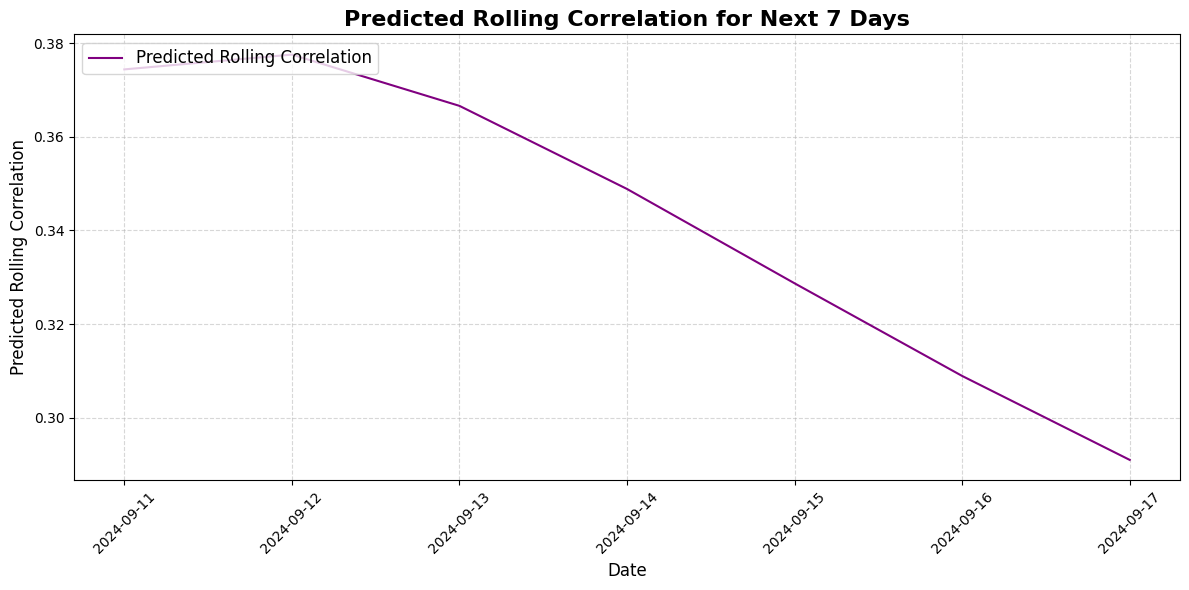

In [23]:
# Plot future predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x=future_df.index, y=future_df['Predicted_Rolling_Correlation'], label='Predicted Rolling Correlation', color='purple')
plt.title('Predicted Rolling Correlation for Next 7 Days', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Rolling Correlation', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()